In [1]:
import numpy as np #numerical computation
import pandas as pd #data wrangling
import matplotlib.pyplot as plt #plotting package
#Next line helps with rendering plots
%matplotlib inline
import matplotlib as mpl #add'l plotting functionality
mpl.rcParams['figure.dpi'] = 400 #high res figures
import graphviz #to visualize decision trees

## Exercise 19: A Decision Tree in Scikit-Learn

Get the data:

In [2]:
df = pd.read_csv('../chapter1/Chapter_1_cleaned_data.csv')

In [3]:
features_and_response = df.columns.tolist()

In [4]:
items_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'EDUCATION_CAT', 'graduate school', 'high school', 'none',
                   'others', 'university']

In [5]:
features_and_response = [item for item in features_and_response if item not in items_to_remove]
features_and_response

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month']

In [6]:
features = features_and_response[:-1]
response = features_and_response[-1]

Get the model from sklearn:

In [7]:
from sklearn.model_selection import train_test_split
from sklearn import tree

The tree library is the library of decision-tree-related classes

Split the data into train and test:

In [8]:
X_train, X_test, y_train, y_test = \
train_test_split(df[features].values, df[response].values, test_size=0.2, random_state=24)

Instantiate the decision tree class (with max depth = 2):

In [9]:
dt = tree.DecisionTreeClassifier(max_depth=2)

Fit the training data:

In [10]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

Export the trained model in a format that can be read by the graphviz package:
- out_file = None: path to the output file
- filled = True: each node will be filled with a color
- rounded = True: nodes will appear with rounded edges
- feature_names: names of the features
- proportion = True: the proportion of samples in each node will be displayed
- class_names: names of the classes

In [11]:
dot_data = tree.export_graphviz(dt, out_file='decision_tree', filled=True, feature_names=features, proportion=True, class_names=['Not defaulted', 'Defaulted'])

Type in the terminal: *dot -Tpng data-science-projects-with-python/chapter5/decision_tree -o data-science-projects-with-python/chapter5/decision_tree.png* to obtain the image.

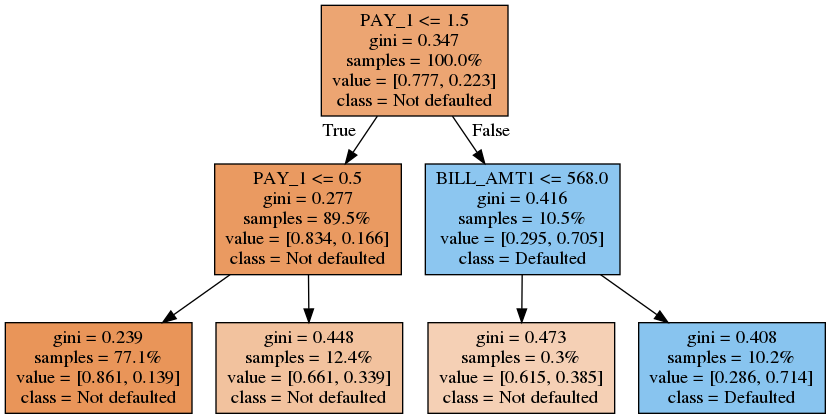

In [12]:
from IPython.display import Image
Image(filename='decision_tree.png') 

Let's confirm that the first node splits data into two groups with 89.5% and 10.5% of traning samples respectively:

In [13]:
shape = X_train.shape
shape

(21331, 17)

Find the index of PAY_1:

In [14]:
PAY_1_index = features.index('PAY_1')

In [15]:
new_shape = X_train[X_train[:,PAY_1_index] <= 1.5].shape
new_shape

(19083, 17)

In [16]:
new_shape[0]/shape[0]

0.8946134733486475

Agrees with decision tree.

The decision tree makes predictions in the following way: it takes into account features of sample and ends up at a leaf node. Then the sample is labeled with the majority class in that leaf node.

## Training Decision Trees: Node Impurity

Let's visualize first of all the missclassification rate at the leafs. That is: if we classify samples as the majority class in that node, what is the probability of a missclassification?

Suppose that pm0 is the proportion of negative samples at the m-th node. Conversely, pm1 is the proportion of positive samples at the m-th node. We can visualize all possibilities by using np.linspace(0.01,0.99,99):

In [17]:
pm0 = np.linspace(0.01,0.99,99)

In [18]:
pm1 = 1 - pm0

The **misclassification rate** is the proportion of samples in the minority class (since that node will classify all samples as the majority class, the proportion of misclassified samples will be the proportion of the minority class):

In [19]:
misclassification_rate = np.minimum(pm0, pm1)

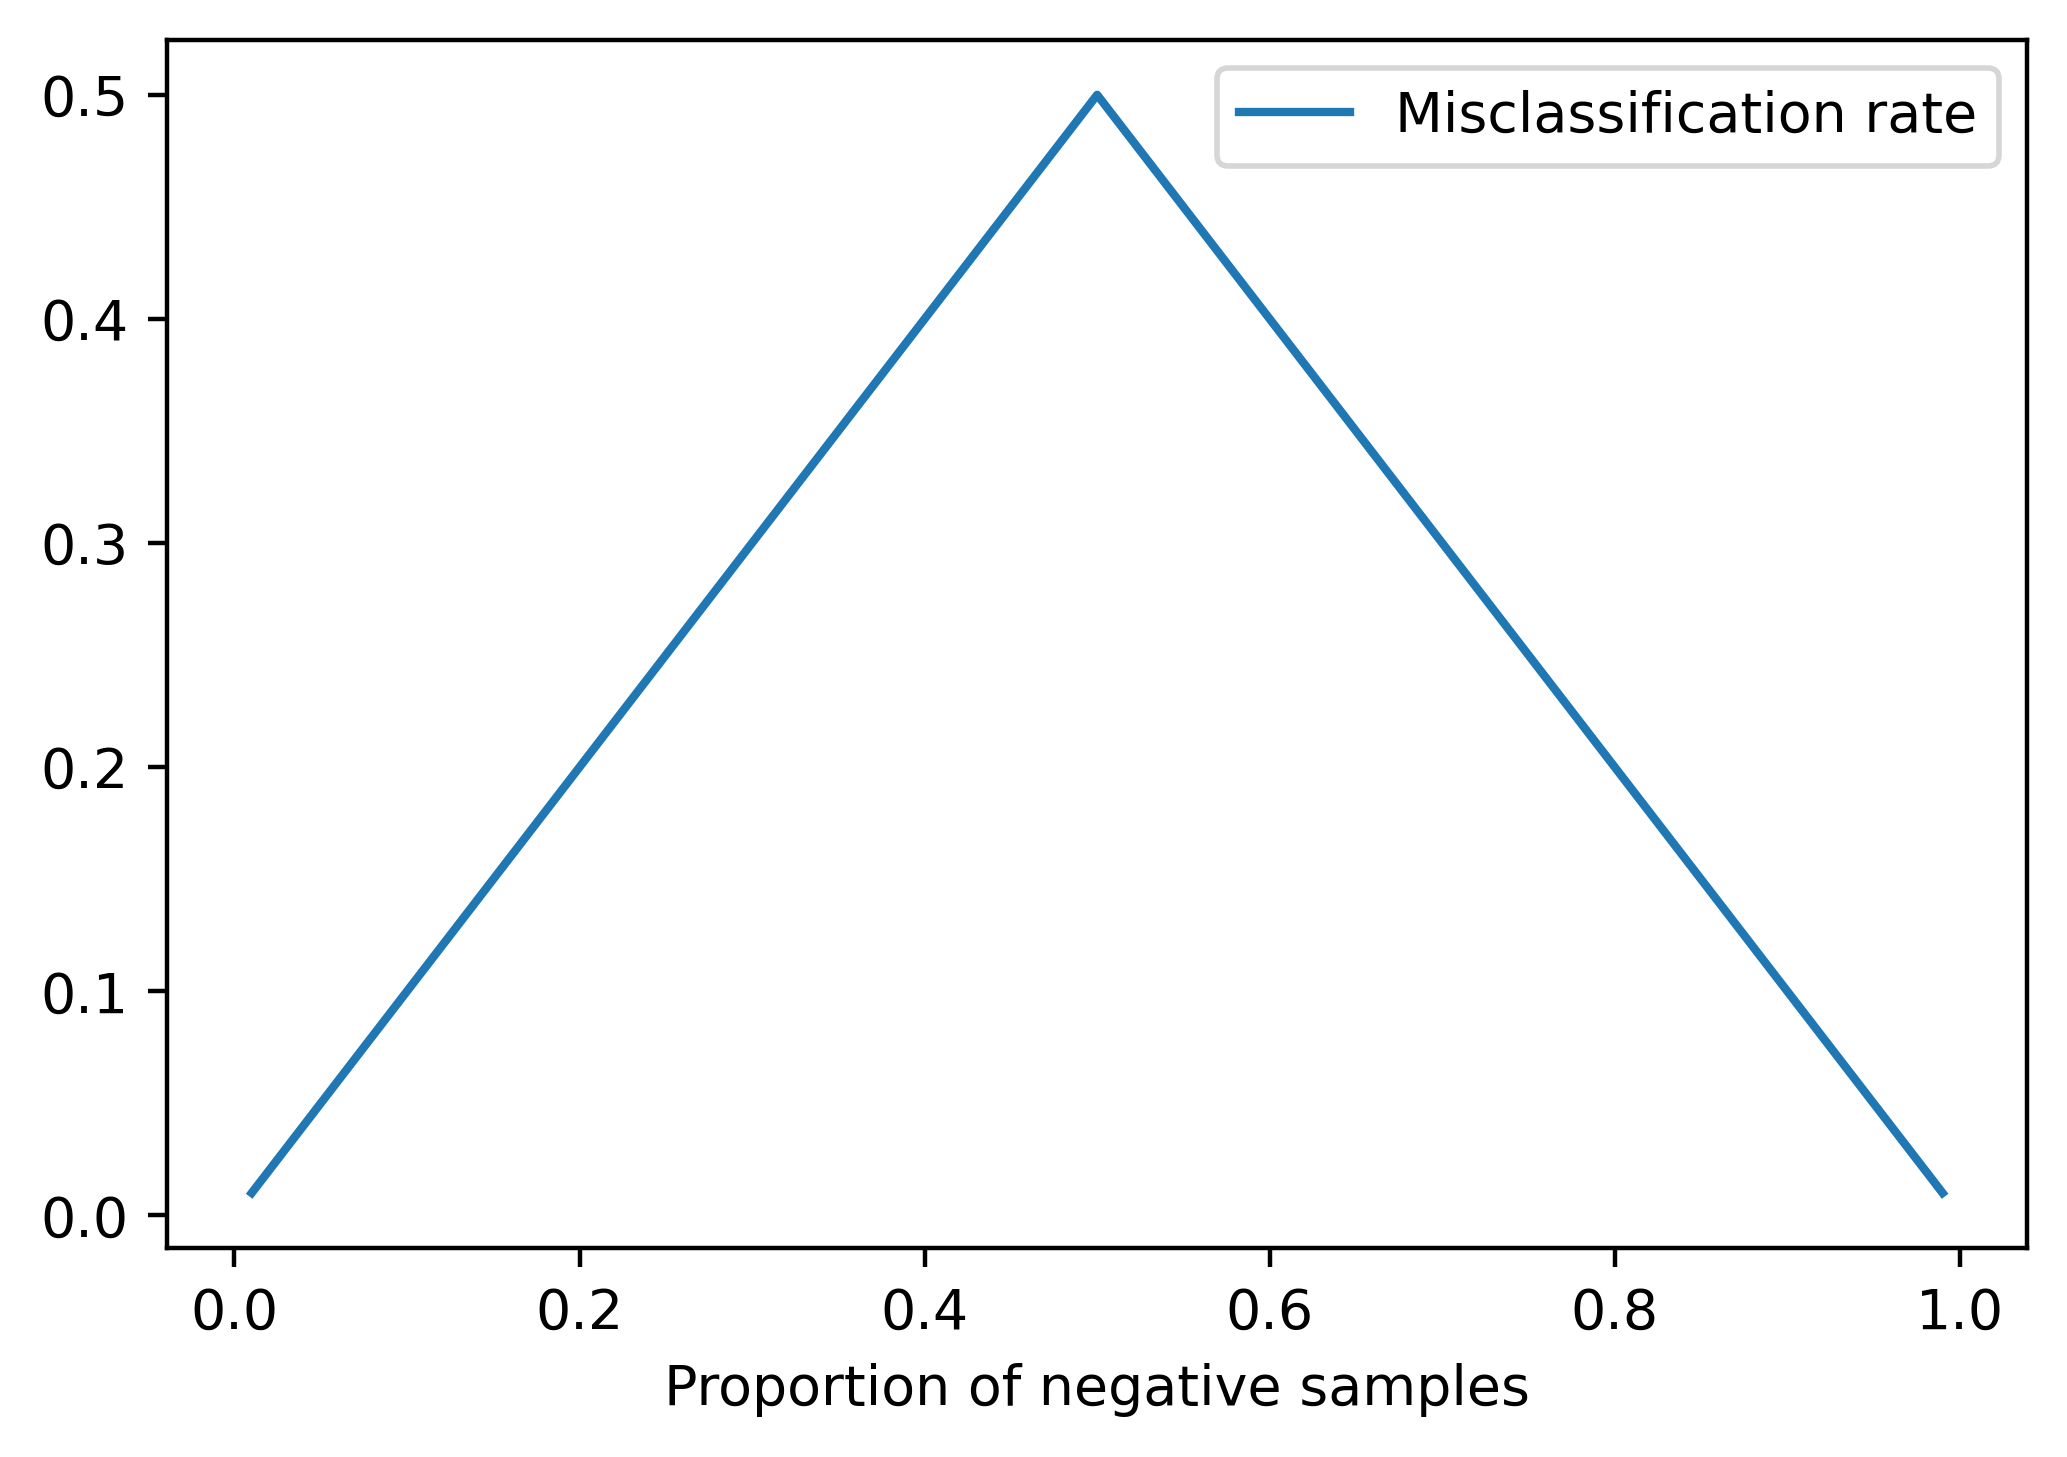

In [20]:
plt.plot(pm0, misclassification_rate, label='Misclassification rate')
plt.xlabel('Proportion of negative samples')
plt.legend()

Other common *cost functions* for measuring node impurity are **Gini impurity** (probability of misclassification if we predict a sample as positive with probability equal to the proportion of positive samples) and **cross-entropy**:

In [21]:
gini = pm0*(1-pm0) + pm1*(1-pm1)

In [22]:
cross_entropy = -pm0*np.log10(pm0) - pm1*np.log10(pm1)

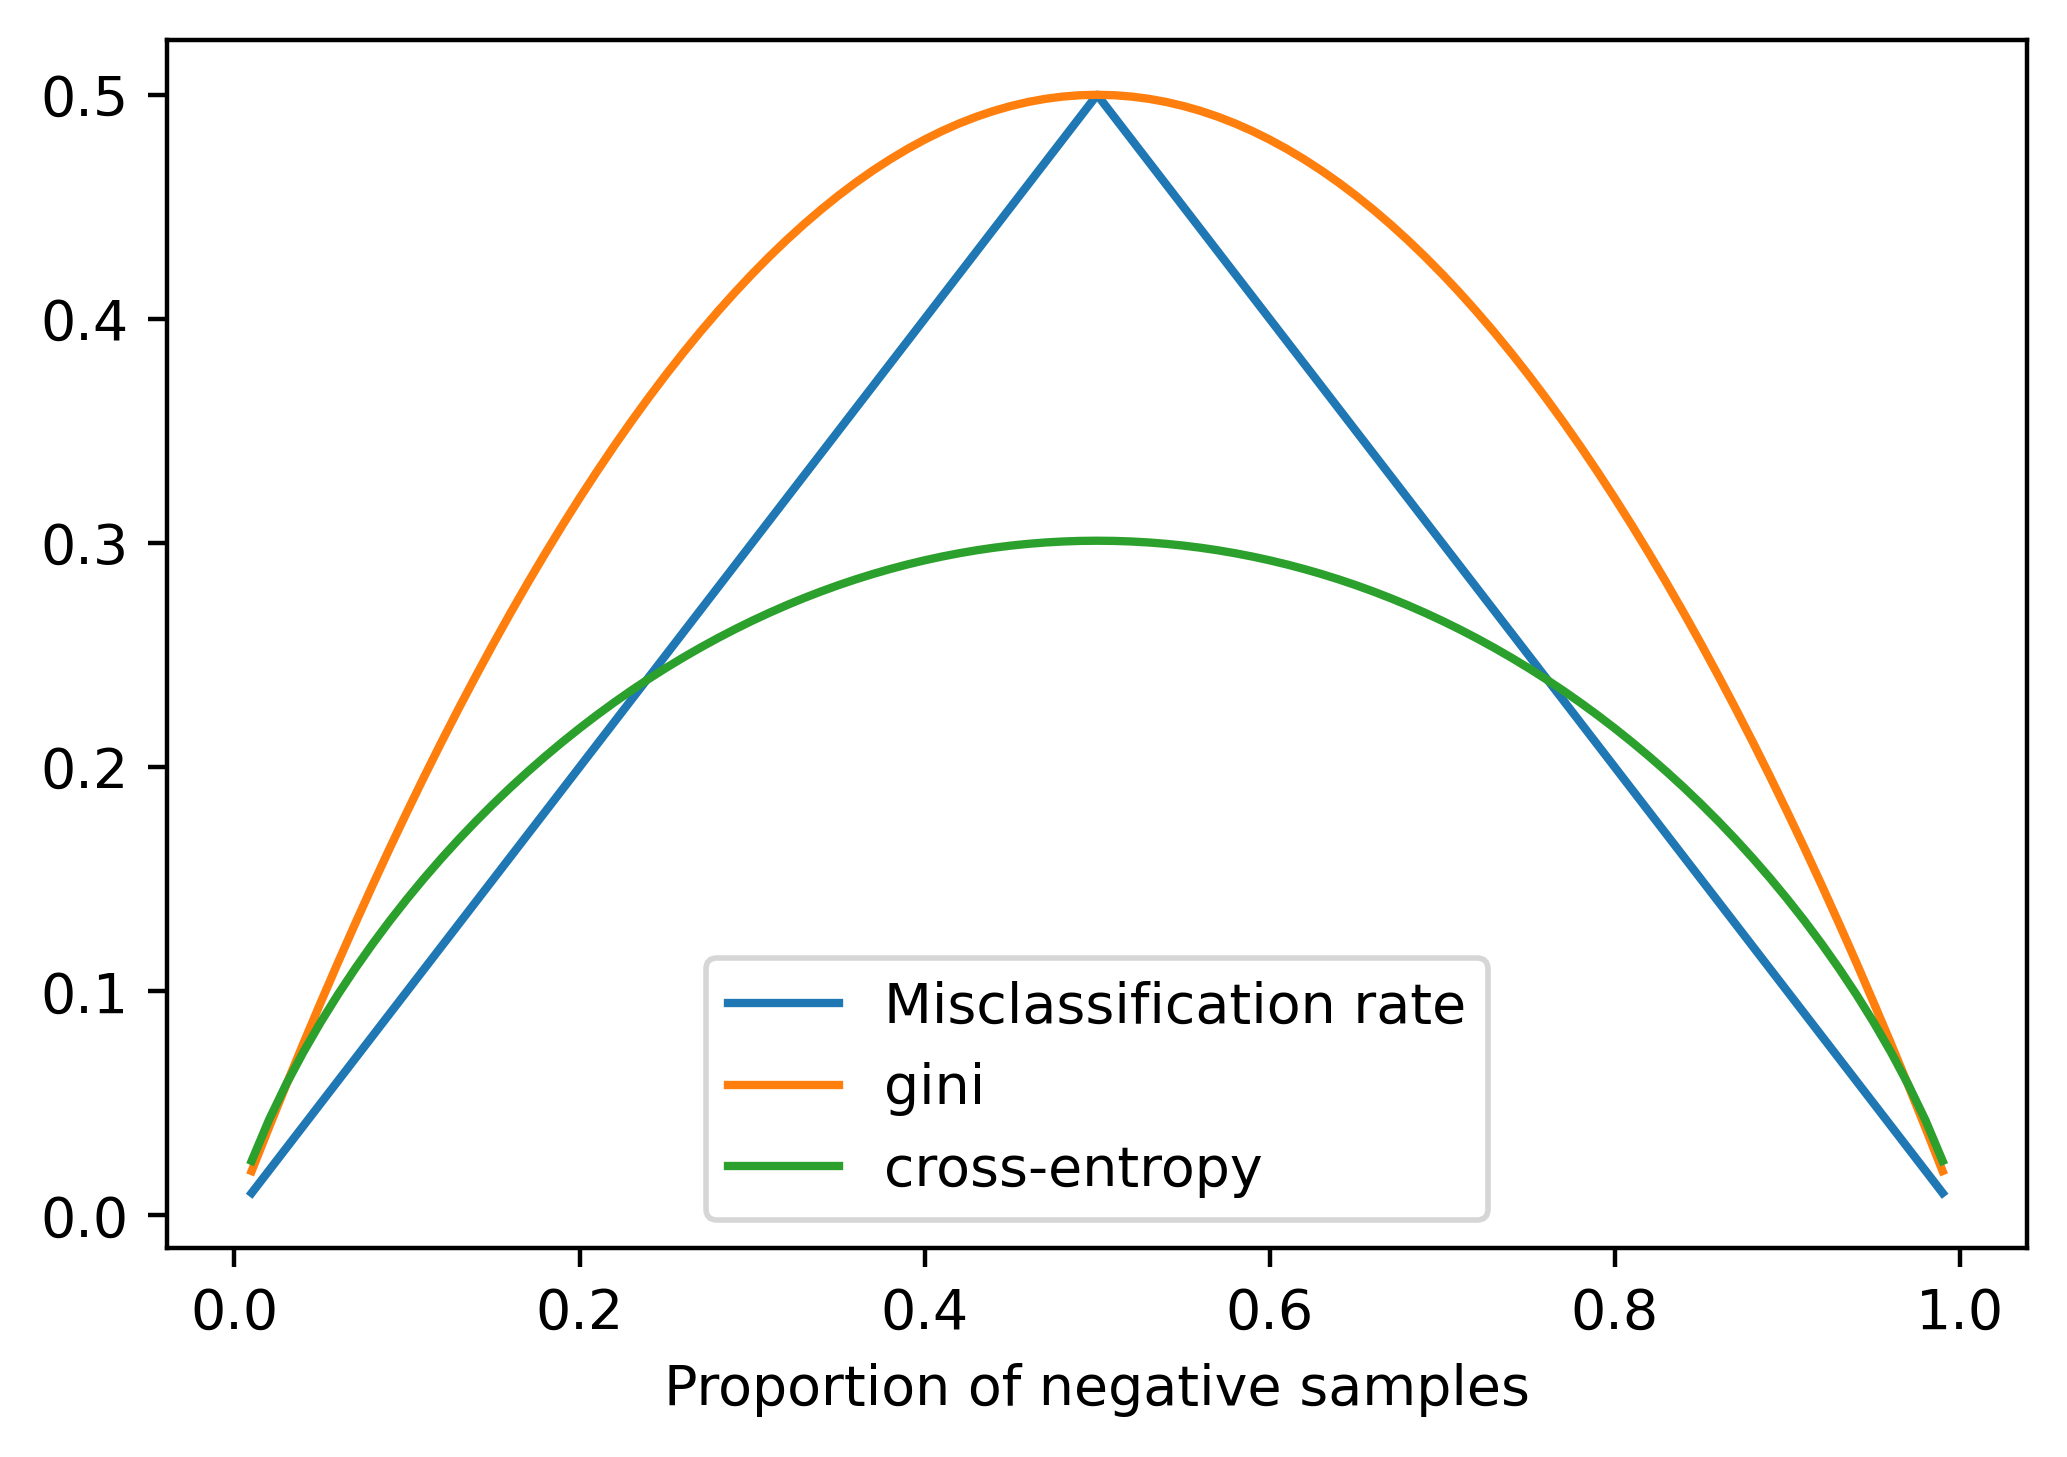

In [23]:
plt.plot(pm0, misclassification_rate, label='Misclassification rate')
plt.plot(pm0, gini, label='gini')
plt.plot(pm0, cross_entropy, label='cross-entropy')
plt.xlabel('Proportion of negative samples')
plt.legend()

## Exercise 20: Finding Optimal Hyperparameters for a Decision Tree

We will use k-fold cross-validation to find optimal hyperparameters. Instead of manually defining the function, we can use **GridSearchCV** function from sklearn, which does it automatically.

In [24]:
from sklearn.model_selection import GridSearchCV

1) Define hyperparameters that we want to search:

We want to fine-tune on max_depth. What range should we be looking at? If we do CV using 4 folds, in each iteration 3/4 of the training data will be used for training.

In [25]:
X_train.shape[0]*3/4

15998.25

A theoretical limitation is that we must have at least 1 sample in each leaf node. So if #leaf_nodes = 2^max_depth -> max_depth = log2(#leaf_nodes). Putting #leaf_nodes = 15998.25 we obtain:

In [26]:
max_depth = np.log2(X_train.shape[0]*3/4)

In [27]:
max_depth

13.965626481261959

So we can explore depths 1-12 (you don't want 1 sample at each leaf because model is likely to overfit)

In [28]:
params = {'max_depth':[1,2,4,6,8,10,12]}

2) Do GridSerach with cv=4 (number of folds) and using the metric 'roc_auc' for evaluating the model (refit=True model will refit to all the data using the best hyperparameters).

In [29]:
cv = GridSearchCV(dt, param_grid=params, scoring='roc_auc', n_jobs=None, refit=True,
                 cv=4, return_train_score=True, verbose=1)

We can do the cv with a .fit method:

In [30]:
cv.fit(X_train, y_train)

Fitting 4 folds for each of 7 candidates, totalling 28 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed:    2.8s finished


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(max_depth=2),
             param_grid={'max_depth': [1, 2, 4, 6, 8, 10, 12]},
             return_train_score=True, scoring='roc_auc', verbose=1)

3) Examine the results:

The cv_results__ gives a dictionary, that is best visualized using pd.DataFrame:

In [31]:
cv_results_df = pd.DataFrame(cv.cv_results_)

In [32]:
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.022574,0.001645,0.002576,0.000350,1,{'max_depth': 1},0.639514,0.643398,0.651891,0.650753,0.646389,0.005136,7,0.648680,0.647384,0.644553,0.644934,0.646388,0.001712
1,0.037817,0.003858,0.002286,0.000217,2,{'max_depth': 2},0.695134,0.699022,0.713376,0.699510,0.701761,0.006917,5,0.704034,0.702700,0.698113,0.702535,0.701845,0.002232
2,0.063986,0.000439,0.002234,0.000067,4,{'max_depth': 4},0.732720,0.740116,0.746946,0.743731,0.740878,0.005294,2,0.756882,0.752256,0.749368,0.753055,0.752890,0.002682
3,0.092209,0.000260,0.002367,0.000023,6,{'max_depth': 6},0.744480,0.746394,0.752069,0.741588,0.746133,0.003831,1,0.782202,0.780125,0.775228,0.774776,0.778083,0.003171
4,0.120460,0.000444,0.002769,0.000408,8,{'max_depth': 8},0.727644,0.729816,0.751516,0.731108,0.735021,0.009603,3,0.811811,0.808245,0.803345,0.802415,0.806454,0.003804
5,0.144644,0.000629,0.002557,0.000020,10,{'max_depth': 10},0.709669,0.704259,0.718902,0.714226,0.711764,0.005425,4,0.849393,0.853938,0.841185,0.836761,0.845319,0.006731
6,0.168629,0.001174,0.002700,0.000038,12,{'max_depth': 12},0.672599,0.655476,0.675401,0.682847,0.671581,0.010024,6,0.887984,0.903375,0.885773,0.875855,0.888247,0.009857


Technically speaking, the best combination of hyperparameters is that with the highest test score (it is an estimation of how well the model would work with unseen data). Let's make a plot showing how the average testing score varies with the max_depth hyperparameter:

Text(0, 0.5, 'ROC AUC')

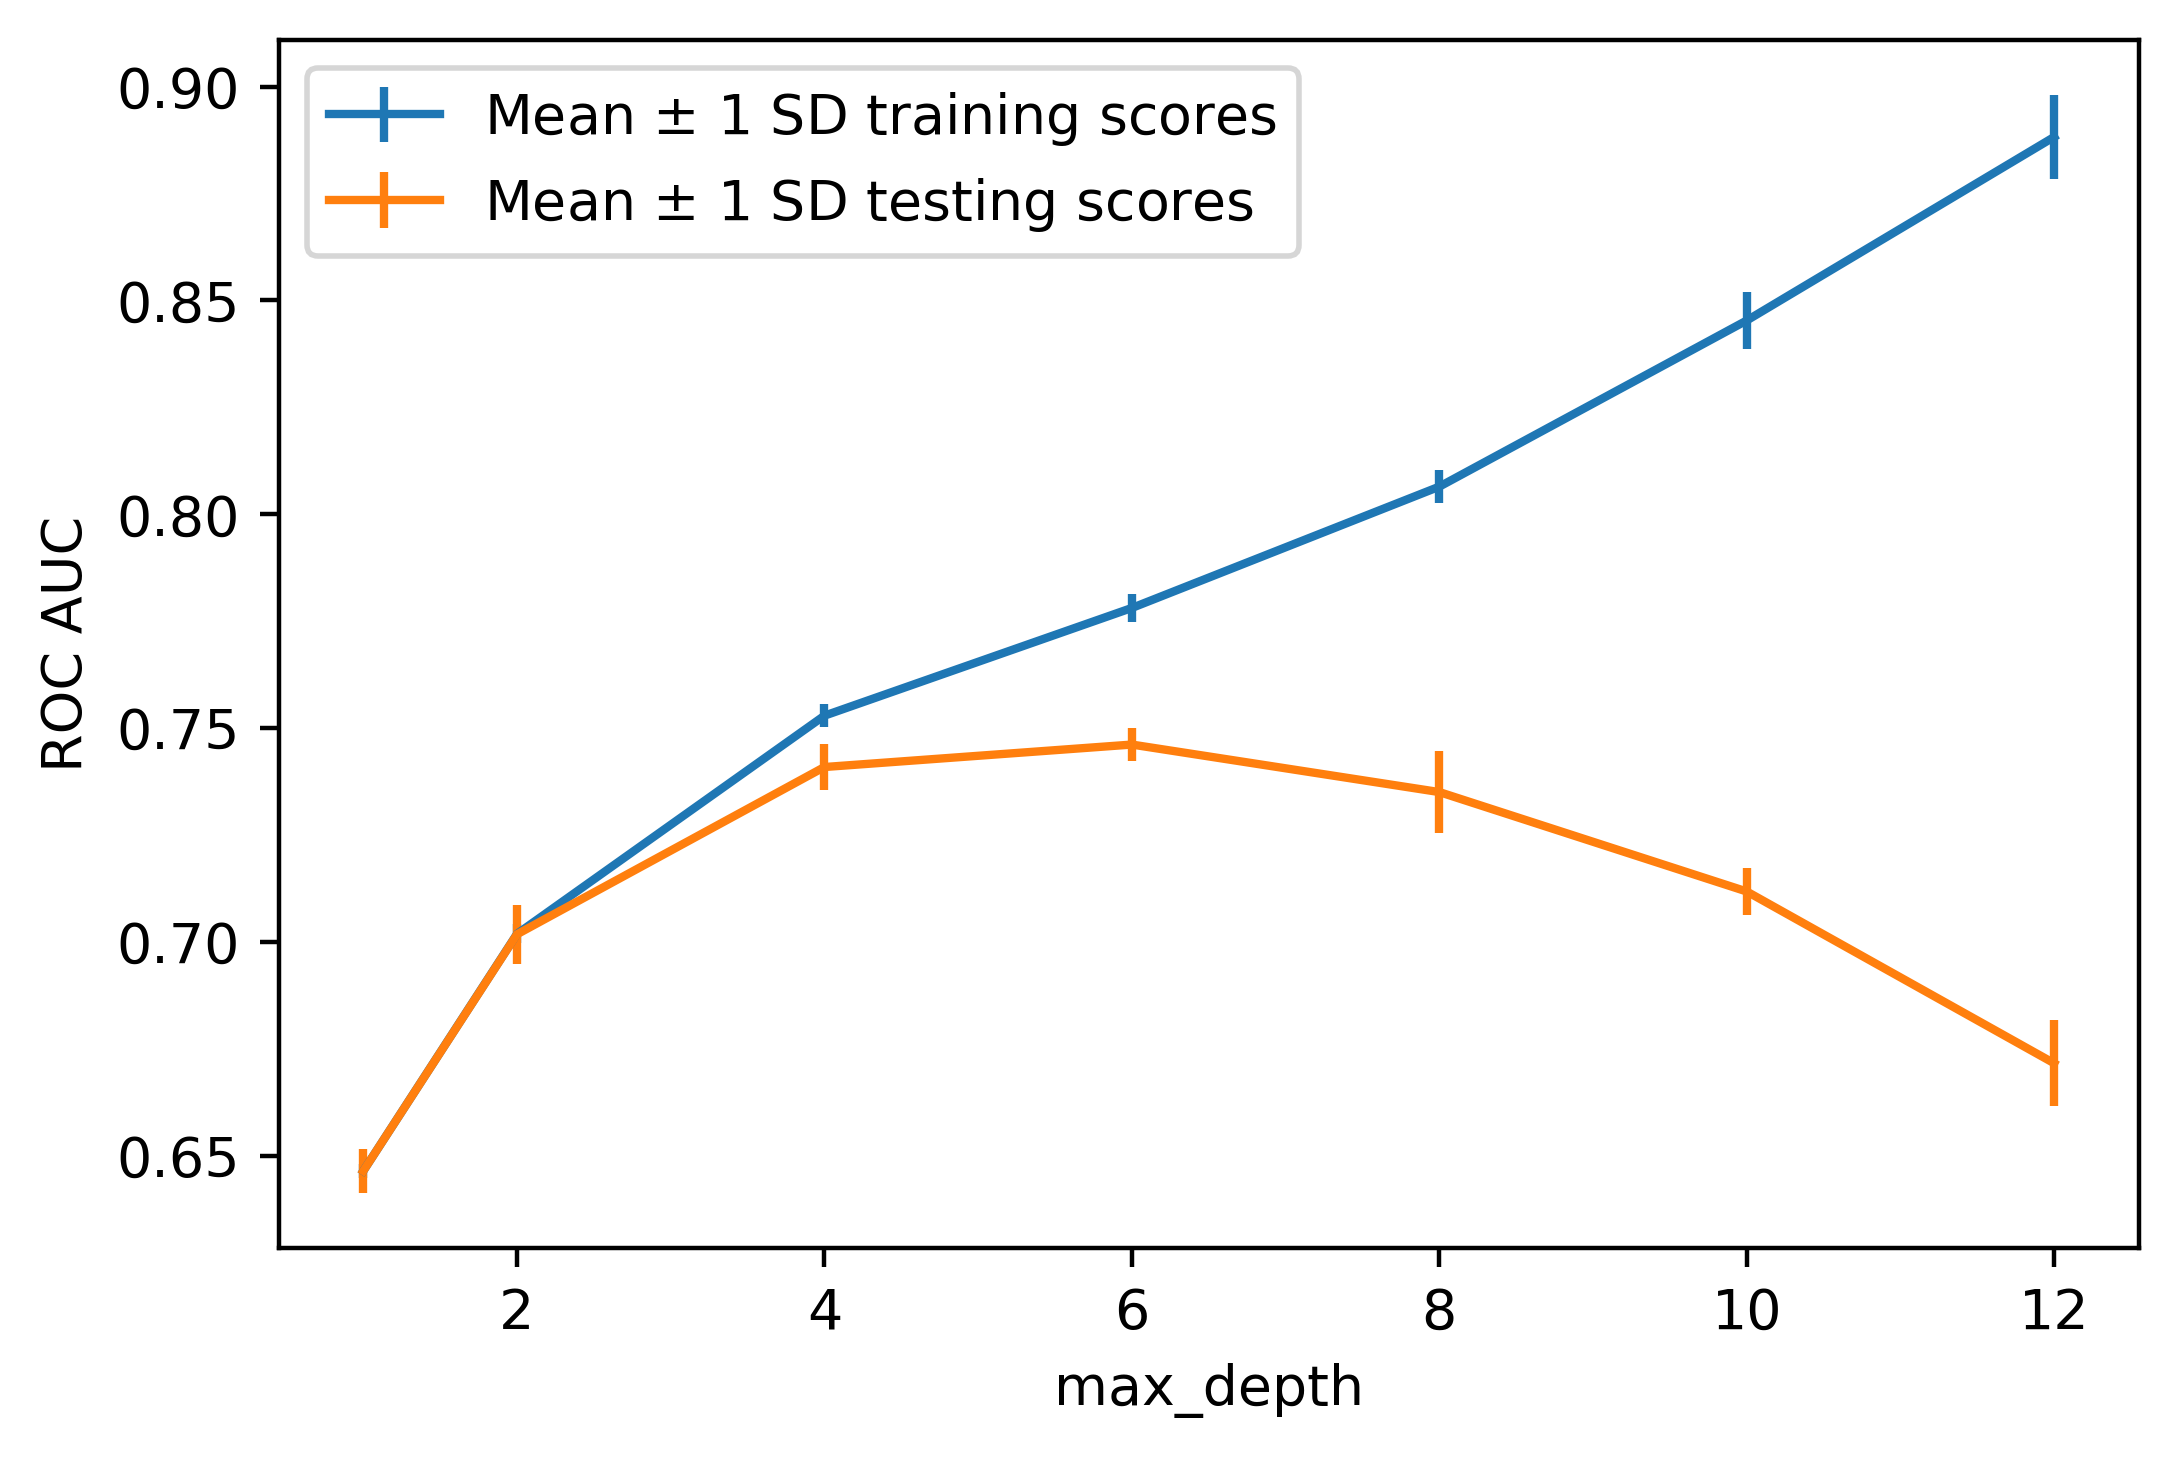

In [33]:
ax = plt.axes()
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_train_score'],
            yerr=cv_results_df['std_train_score'],
            label='Mean $\pm$ 1 SD training scores')
ax.errorbar(cv_results_df['param_max_depth'],
            cv_results_df['mean_test_score'],
            yerr=cv_results_df['std_test_score'],
            label='Mean $\pm$ 1 SD testing scores')
ax.legend()
plt.xlabel('max_depth')
plt.ylabel('ROC AUC')

## Exercise 21: Fitting a Random Forest 

In [34]:
from sklearn.ensemble import RandomForestClassifier

The RandomForestClassifier takes the following arguments:
1) n_estimators = # decision trees in the ensemble
2) min_samples_split = minimum # samples to split node
3) min_samples_leaf = minimum # samples in leaf node
4) max_features = search a random selection of the square root of the # features at each split
5) bootstrap = True if perform bootstrapping (that is, sample from dataset with replacement for each tree so dataset is different for each decision tree)

In [35]:
rf = RandomForestClassifier\
(n_estimators=10, criterion='gini', max_depth=3,
min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0,
max_features='auto', max_leaf_nodes=None, bootstrap=True, random_state=4)

Create a parameter grid to search in CV:

In [36]:
rf_params_ex = {'n_estimators':list(range(10,110,10))}

Do grid search with CV:

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
cv = GridSearchCV\
(rf, rf_params_ex, cv=4, scoring='roc_auc',
 verbose=1, return_train_score=True)

Fit the cross-validation object:

In [39]:
cv.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   22.6s finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [41]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.105372,0.009561,0.005726,0.000459,10,{'n_estimators': 10},0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,10,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.187851,0.002376,0.008138,0.000062,20,{'n_estimators': 20},0.745612,0.753712,0.777616,0.771737,0.762169,0.012998,9,0.772819,0.771499,0.765944,0.765395,0.768914,0.003284
2,0.271926,0.001267,0.010917,0.000057,30,{'n_estimators': 30},0.747259,0.754154,0.777954,0.771825,0.762798,0.012524,7,0.774655,0.772100,0.765026,0.766697,0.769620,0.003910
3,0.361445,0.001065,0.013697,0.000050,40,{'n_estimators': 40},0.746682,0.754553,0.777709,0.773134,0.763020,0.012813,4,0.774300,0.772642,0.765051,0.765876,0.769467,0.004057
4,0.462503,0.006530,0.018268,0.003019,50,{'n_estimators': 50},0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,1,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
5,0.545085,0.001436,0.019356,0.000077,60,{'n_estimators': 60},0.748437,0.755604,0.779478,0.770978,0.763624,0.012252,2,0.775419,0.773615,0.766133,0.767032,0.770550,0.004031
6,0.634688,0.001497,0.022172,0.000156,70,{'n_estimators': 70},0.747491,0.754465,0.779104,0.771023,0.763021,0.012620,3,0.774420,0.773379,0.765960,0.766174,0.769983,0.003934
7,0.739515,0.018323,0.025291,0.000502,80,{'n_estimators': 80},0.747424,0.754488,0.778753,0.770872,0.762884,0.012502,5,0.774234,0.773257,0.765978,0.766220,0.769922,0.003840
8,0.816126,0.003356,0.027777,0.000221,90,{'n_estimators': 90},0.747097,0.753794,0.778507,0.770426,0.762456,0.012571,8,0.774095,0.772973,0.766022,0.765748,0.769709,0.003846
9,0.904253,0.001903,0.030697,0.000104,100,{'n_estimators': 100},0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,6,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750


Now let's plot the mean testing ROC AUC and the std wrt number of trees:

Text(0, 0.5, 'ROC AUC test score $\\pm$ 1 STD')

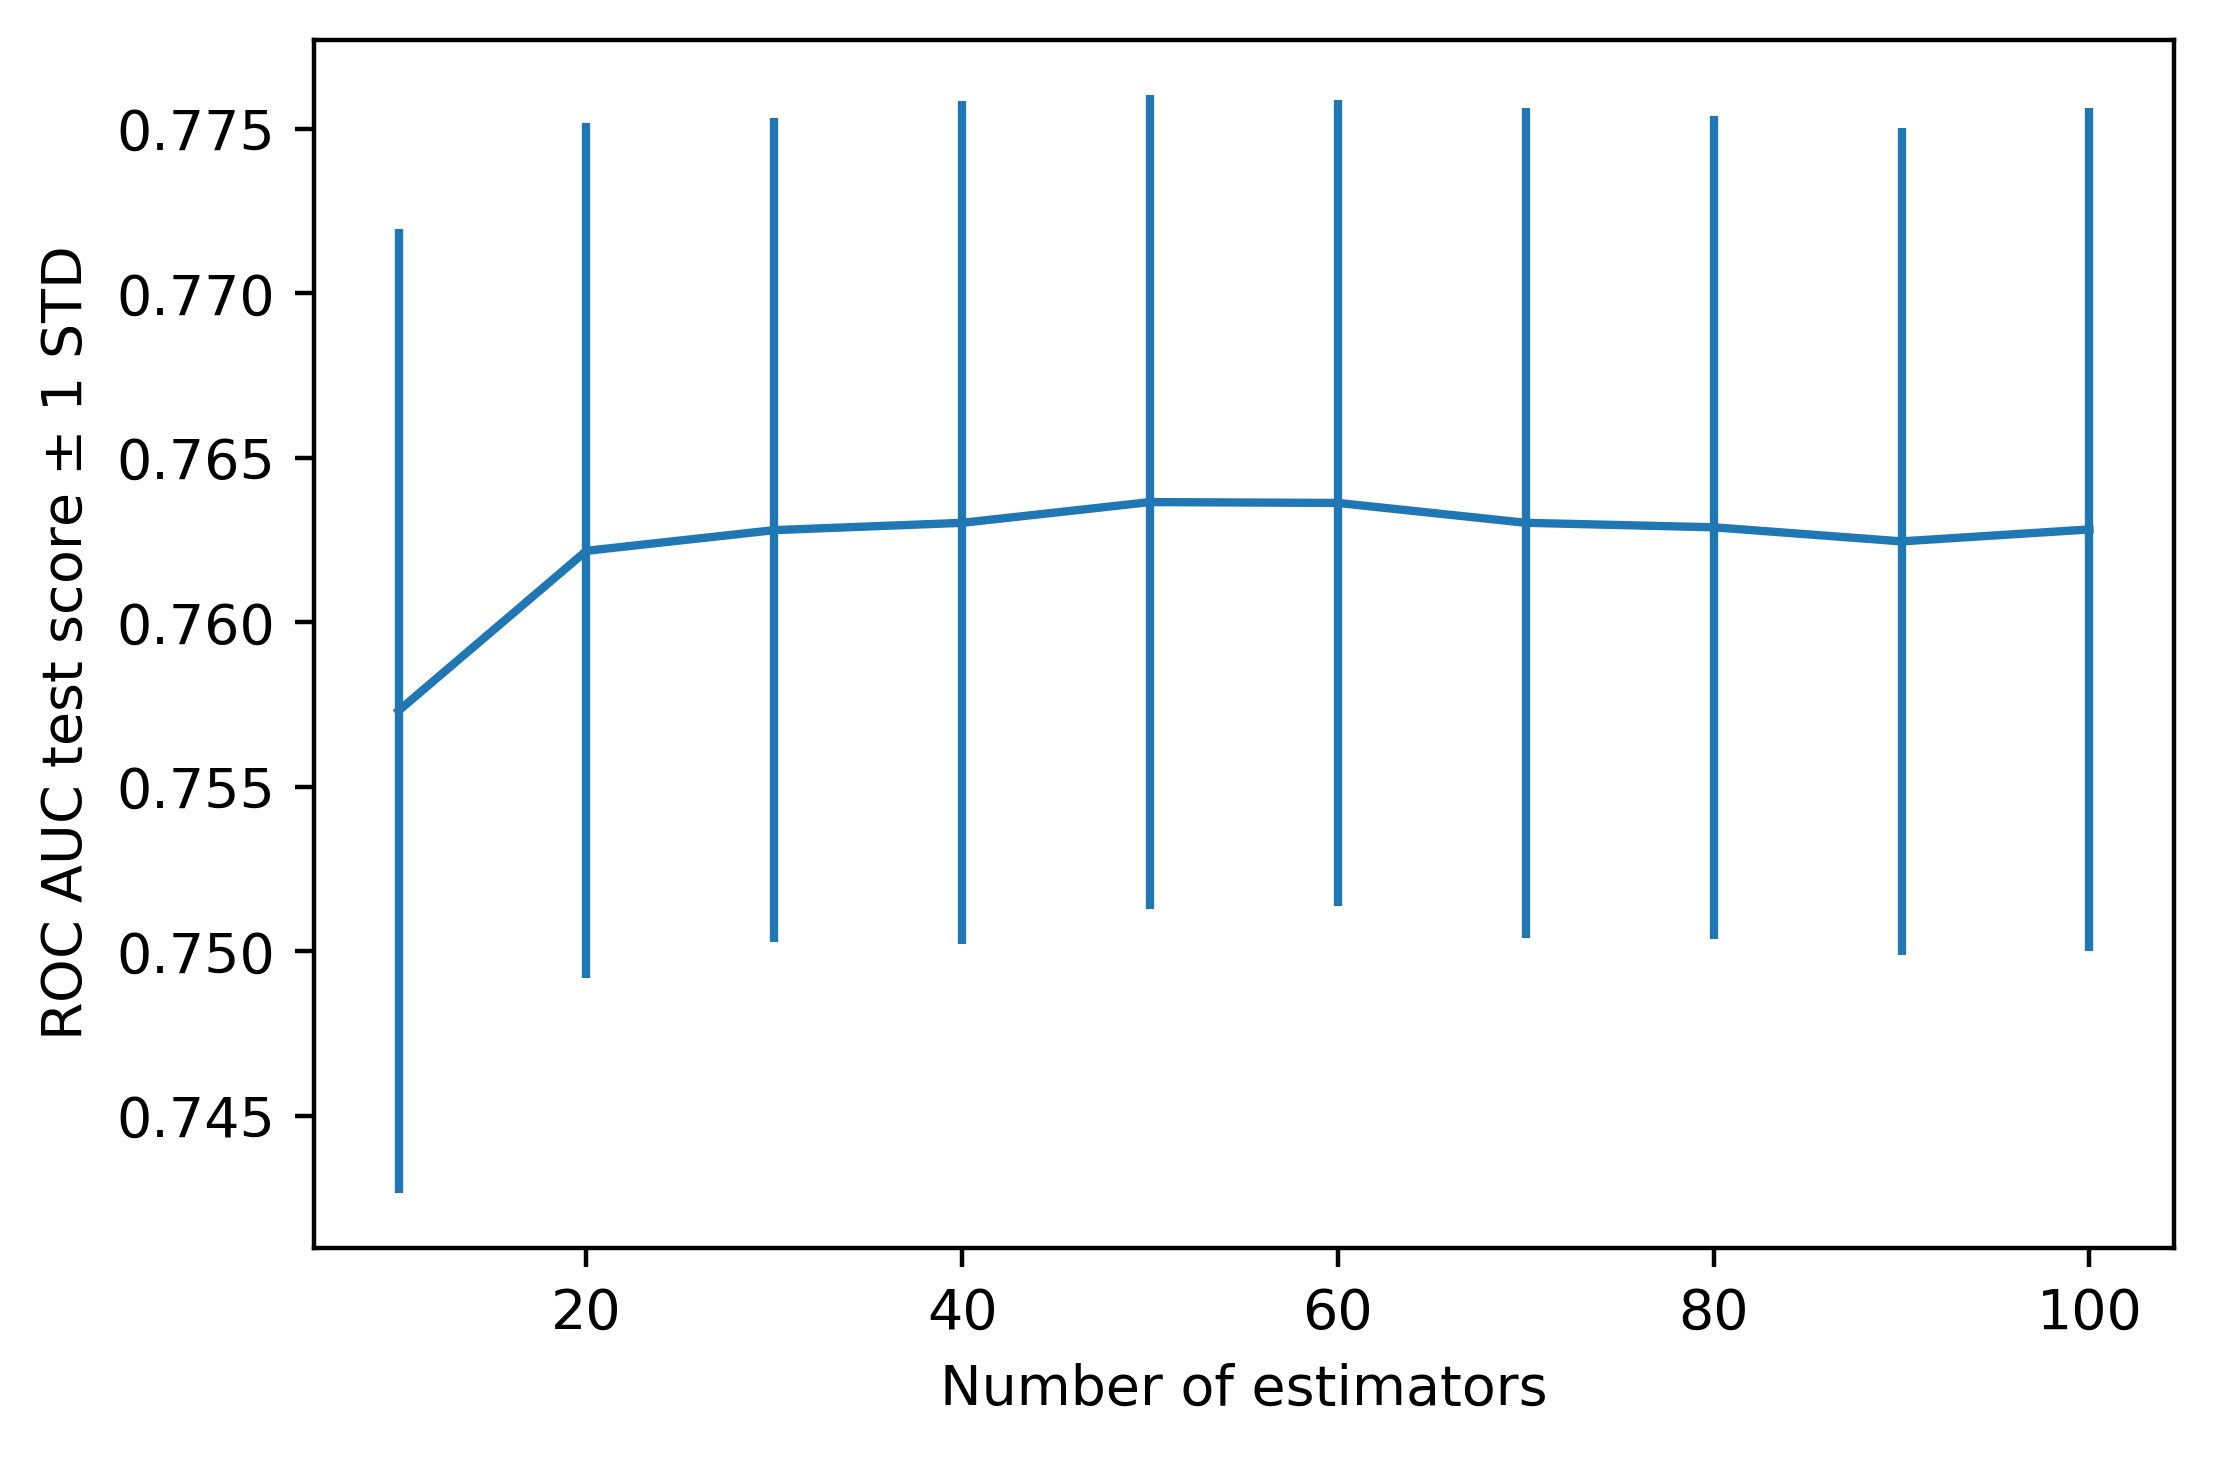

In [44]:
axes = plt.axes()
axes.errorbar\
(cv_results_df['param_n_estimators'],
 cv_results_df['mean_test_score'],
 yerr = cv_results_df['std_test_score'])
axes.set_xlabel('Number of estimators')
axes.set_ylabel('ROC AUC test score $\pm$ 1 STD')

With a random forest we obtain a test score of 0.763651, which is higher than with all of the prior methods (it was 0.74...). 

However we can also notice that there is also more variability between the folds than we saw with the decision tree (higher std). However even the lowest score is higher than what we obtained before.

To see the best hyperparameters from cross-validation:

In [45]:
cv.best_params_

{'n_estimators': 50}

## Random Forest for feature selection

We can also compute the *feature importance* of each feature. The *feature importance* of a random forest are a measure of how useful each of the features were when growing the trees. This usefulness is measured by using a combination of the fraction of training samples that were split during that feature, and the decrease in node impurity that resulted.

In [47]:
features

['LIMIT_BAL',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

In [50]:
feat_import_df = pd.DataFrame\
(data=cv.best_estimator_.feature_importances_,
 index=features,
columns =['feature importance'])
feat_import_df 

,feature importance
LIMIT_BAL,0.079265
EDUCATION,0.001630
MARRIAGE,0.000170
AGE,0.000459
PAY_1,0.609609
BILL_AMT1,0.008574
BILL_AMT2,0.022422
BILL_AMT3,0.013321
BILL_AMT4,0.013454
BILL_AMT5,0.011264


Let's sort by value:

In [51]:
feat_import_df.sort_values('feature importance', ascending=False)

,feature importance
PAY_1,0.609609
PAY_AMT1,0.094123
LIMIT_BAL,0.079265
PAY_AMT3,0.047067
PAY_AMT2,0.035393
BILL_AMT2,0.022422
PAY_AMT4,0.021164
PAY_AMT5,0.015962
BILL_AMT6,0.014293
BILL_AMT4,0.013454


Notice how the top 5 features are the same as we saw with the ANOVA test.

## Activity 5: CV Grid Search with Random Forest 

Repeat the previous but searching over two hyperparameters:

In [56]:
params=\
{'max_depth':[3,6,9,12],
 'n_estimators':[10,50,100,200]}

In [57]:
cv = GridSearchCV\
(rf, params, scoring='roc_auc', cv=4, verbose=1, return_train_score=True)

In [58]:
cv.fit(X_train, y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:  2.3min finished


GridSearchCV(cv=4,
             estimator=RandomForestClassifier(max_depth=3, n_estimators=10,
                                              random_state=4),
             param_grid={'max_depth': [3, 6, 9, 12],
                         'n_estimators': [10, 50, 100, 200]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [60]:
cv_results_df = pd.DataFrame(cv.cv_results_)
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,0.110544,0.011395,0.005889,0.000650,3,10,"{'max_depth': 3, 'n_estimators': 10}",0.739183,0.746599,0.772127,0.771322,0.757308,0.014656,15,0.767973,0.767158,0.760550,0.763683,0.764841,0.002955
1,0.543860,0.063500,0.019760,0.002821,3,50,"{'max_depth': 3, 'n_estimators': 50}",0.748009,0.755878,0.779465,0.771250,0.763651,0.012379,12,0.775241,0.774025,0.765732,0.766947,0.770486,0.004191
2,1.172319,0.104462,0.037044,0.005360,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.747221,0.753924,0.779195,0.770937,0.762819,0.012811,13,0.774340,0.773598,0.766103,0.766914,0.770238,0.003750
3,2.201274,0.294716,0.069116,0.010397,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.747454,0.753057,0.777644,0.771729,0.762471,0.012550,14,0.774453,0.773534,0.766139,0.767404,0.770382,0.003653
4,0.166192,0.005615,0.006370,0.000123,6,10,"{'max_depth': 6, 'n_estimators': 10}",0.752905,0.758904,0.780036,0.774017,0.766466,0.010980,11,0.795911,0.796476,0.793695,0.796446,0.795632,0.001141
5,0.847103,0.031165,0.022588,0.002217,6,50,"{'max_depth': 6, 'n_estimators': 50}",0.760089,0.765251,0.788567,0.778669,0.773144,0.011193,8,0.807081,0.805109,0.799176,0.801229,0.803149,0.003113
6,1.949481,0.101331,0.054354,0.010012,6,100,"{'max_depth': 6, 'n_estimators': 100}",0.760964,0.765515,0.788793,0.778936,0.773552,0.011004,7,0.808194,0.806130,0.800846,0.803123,0.804573,0.002808
7,3.870812,0.124269,0.091685,0.002320,6,200,"{'max_depth': 6, 'n_estimators': 200}",0.761481,0.765319,0.787854,0.779745,0.773600,0.010682,6,0.808276,0.806853,0.800682,0.804006,0.804954,0.002906
8,0.272146,0.009973,0.009101,0.000512,9,10,"{'max_depth': 9, 'n_estimators': 10}",0.757853,0.755444,0.781544,0.773823,0.767166,0.010899,10,0.854161,0.856197,0.850317,0.852039,0.853178,0.002211
9,1.348020,0.057543,0.031952,0.002423,9,50,"{'max_depth': 9, 'n_estimators': 50}",0.763956,0.764420,0.786690,0.780255,0.773830,0.009908,4,0.867242,0.871380,0.868213,0.867390,0.868557,0.001672


In [61]:
cv.best_params_

{'max_depth': 9, 'n_estimators': 200}

Looks like 9 is the best max_depth. And the more trees the better.

Let's visualize the results with a heat plot.

In [62]:
x, y = np.meshgrid(range(5), range(5))

In [74]:
cv_results_df['mean_test_score'].values.reshape(4,4)

array([[0.75730766, 0.76365051, 0.76281941, 0.76247114],
       [0.7664656 , 0.77314378, 0.77355231, 0.77359992],
       [0.76716589, 0.77383029, 0.77496884, 0.77619851],
       [0.75722825, 0.77157003, 0.77381473, 0.77549938]])

[Text(0, 0.5, '3'), Text(0, 1.5, '6'), Text(0, 2.5, '9'), Text(0, 3.5, '12')]

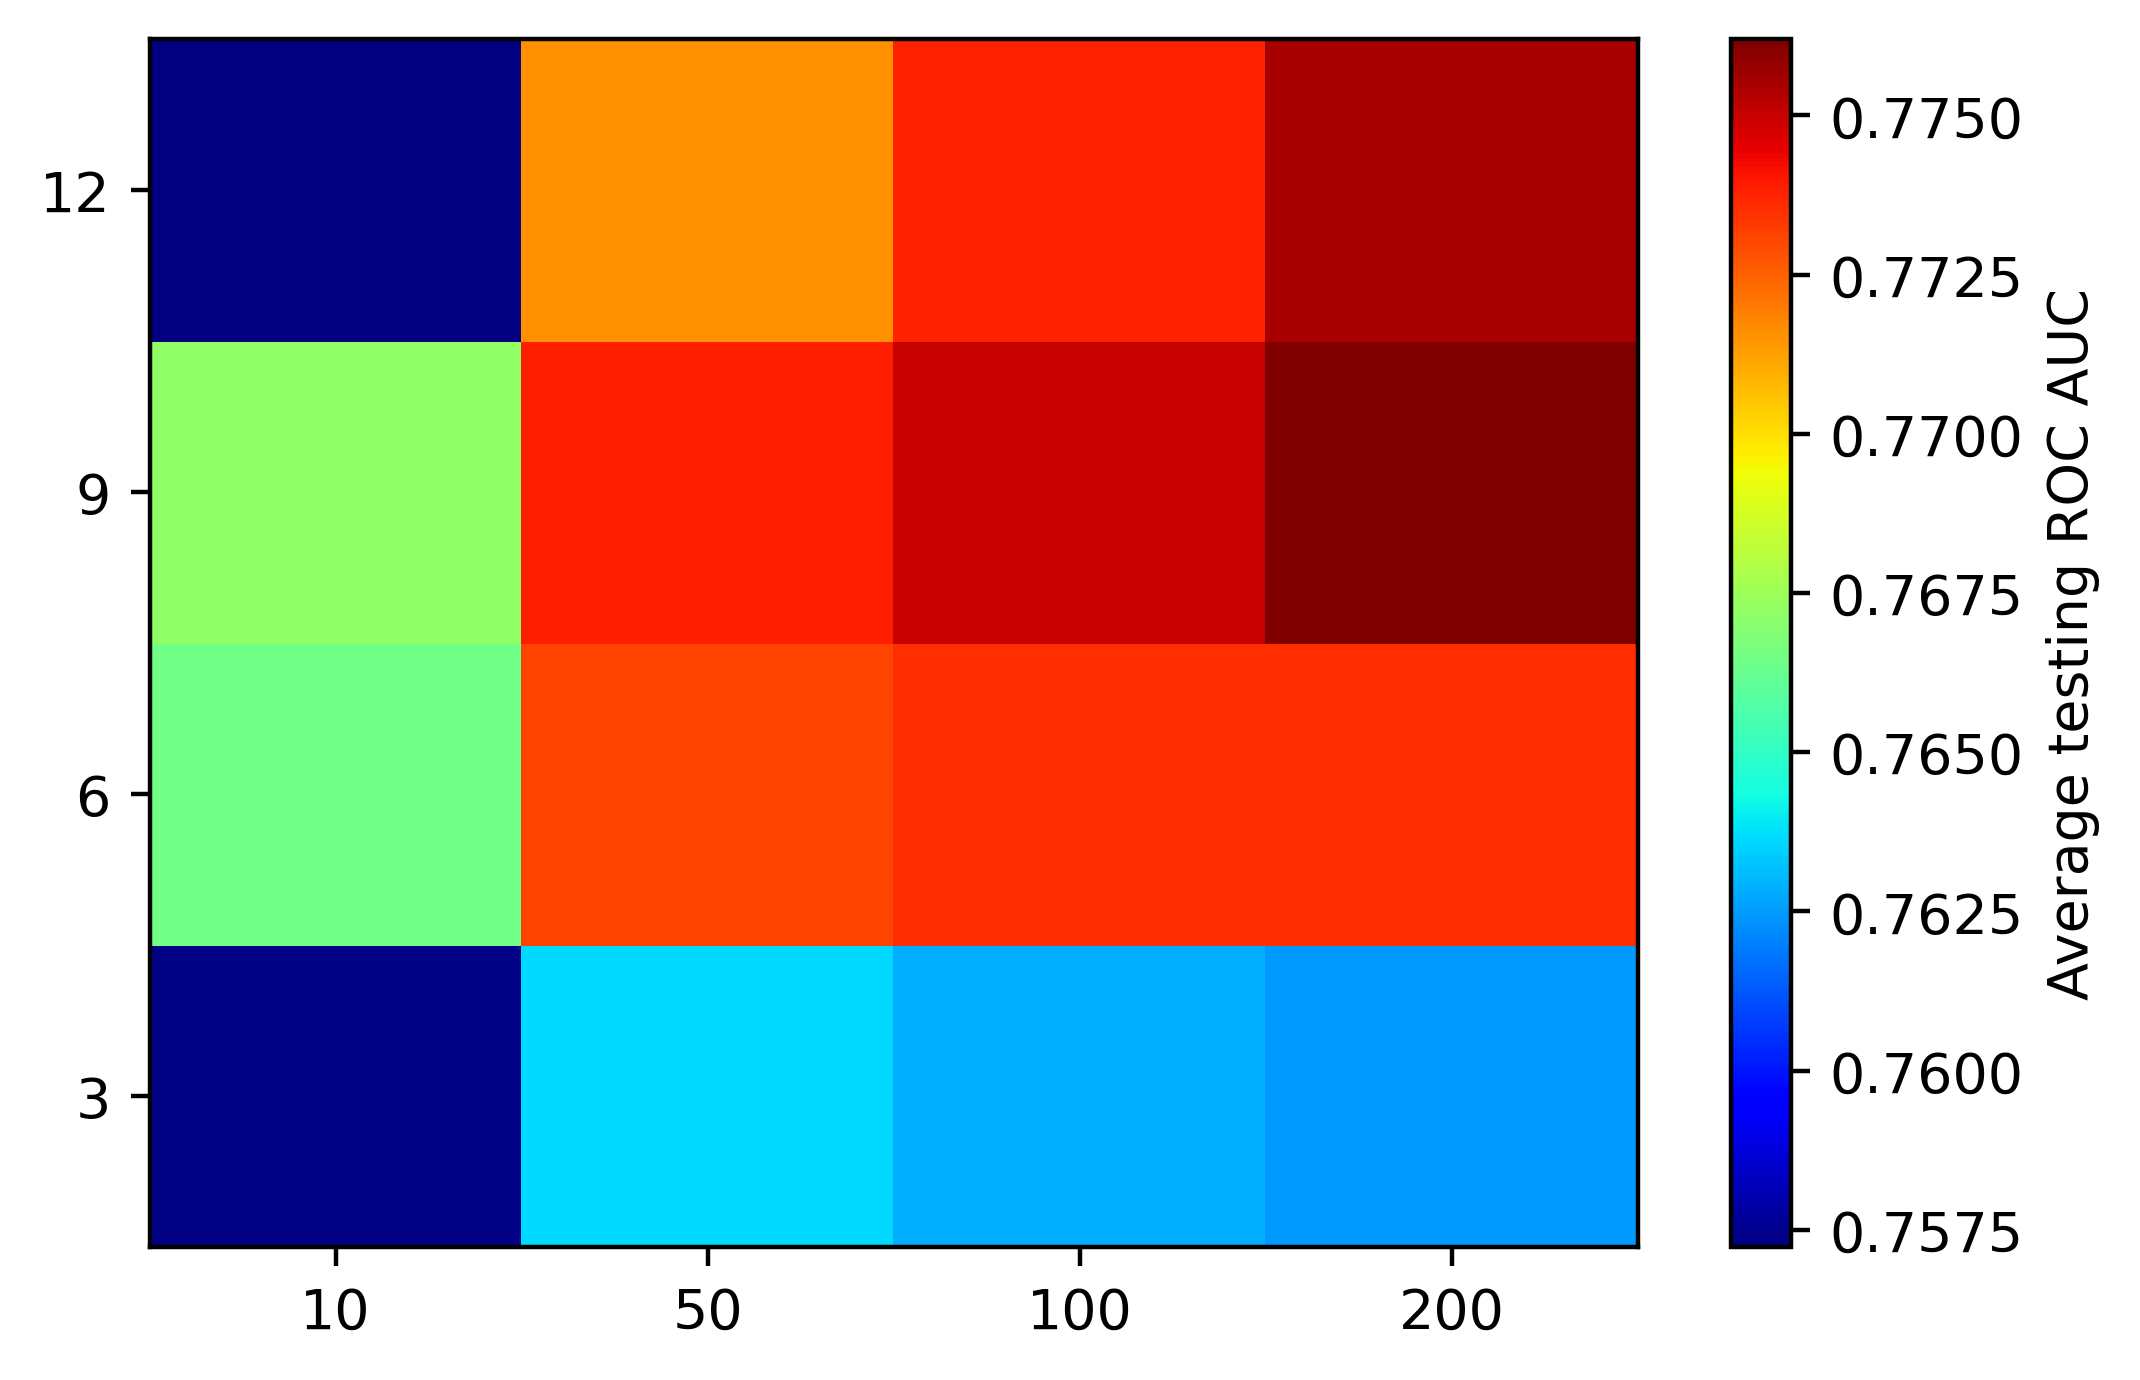

In [77]:
ax = plt.axes()
pcolor_graph = ax.pcolormesh(x, y, cv_results_df['mean_test_score'].values.reshape(4, 4),
                            cmap=plt.cm.jet)
plt.colorbar(pcolor_graph, label='Average testing ROC AUC')
ax.set_xticks([0.5, 1.5, 2.5, 3.5])
ax.set_yticks([0.5, 1.5, 2.5, 3.5])
ax.set_xticklabels(params['n_estimators'])
ax.set_yticklabels(params['max_depth'])

Calculate the feature importance:

In [81]:
cv.best_estimator_.feature_importances_

ValueError: cannot reshape array of size 17 into shape (4,4)

In [84]:
feat_imp_df = pd.DataFrame(cv.best_estimator_.feature_importances_, index=features, columns=['feature importance'])
feat_imp_df.sort_values('feature importance', ascending=False)

,feature importance
PAY_1,0.437439
LIMIT_BAL,0.059961
PAY_AMT1,0.059434
PAY_AMT2,0.045518
PAY_AMT3,0.043299
BILL_AMT1,0.042195
BILL_AMT2,0.041562
BILL_AMT3,0.037268
PAY_AMT4,0.034321
BILL_AMT4,0.034123
